In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import zoom
from rasterio.warp import reproject, Resampling
from scipy.spatial import cKDTree
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, median_absolute_error, explained_variance_score, max_error, mean_squared_log_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, pearsonr, kendalltau
from xgboost import XGBClassifier, plot_importance 
import seaborn as sns
import matplotlib.colors as mcolors
from xgboost import XGBRegressor

In [2]:
paths = {
'fault': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\fault_distance_raster.tif",
'litho': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Litho_Gold.tif",
'au': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Au_ppb.tif",
'intrusive': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Intrusive_Gold.tif",
'tmi': r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Resampled_TMI.tif",
'geomorpho' : r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Geomorphological_Classification.tif", }

In [3]:
target_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Target_Map_Binary_Gold.tif"
target2_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters\Target_Map_Gold.tif"

# [1] Using XGBClassifier

In [62]:
# Load and flatten all rasters
features = {}
for key, path in paths.items():
    with rasterio.open(path) as src:
        data = src.read(1)
        features[key] = data.flatten()
        profile = src.profile  # save for later use

# Combine into a DataFrame
df = pd.DataFrame(features)

In [66]:
with rasterio.open(target_dir) as src:
    y = src.read(1).flatten()

df['target'] = y

# Drop NaNs (mask where no values in any predictor or target)
df = df.dropna()

In [68]:
df

,fault,litho,au,intrusive,tmi,geomorpho,target
0,1.000000,0.0,0.000000,0.0,-59.793289,0.0,0.0
1,1.000000,0.0,0.000000,0.0,-56.735188,0.0,0.0
2,1.000000,0.0,0.000000,0.0,-59.508698,0.0,0.0
3,101.000000,0.0,0.000000,0.0,-59.120945,0.0,0.0
4,101.000000,0.0,0.000000,0.0,-53.886196,0.0,0.0
...,...,...,...,...,...,...,...
4181632,54747.140625,0.0,1.251632,0.0,0.000000,0.0,0.0
4181633,54844.503906,0.0,1.251626,0.0,0.000000,0.0,0.0
4181634,54941.878906,0.0,1.251620,0.0,0.000000,0.0,0.0
4181635,55039.257812,0.0,1.251615,0.0,0.000000,0.0,0.0


In [70]:
# Separate gold and background
df_gold = df[df['target'] == 1]
df_bg = df[df['target'] == 0]

print(f"Gold samples: {len(df_gold)}")
print(f"Background samples: {len(df_bg)}")

Gold samples: 45
Background samples: 4181592


In [72]:
df[df['target'] == 1]['geomorpho'].value_counts()

geomorpho
2.0    32
1.0    12
4.0     1
Name: count, dtype: int64

###### Here, with 45 known gold samples, 12 samples are being classified in geomorpho code:1 
###### Initial case: With only 45 gold points, unless those gold pixels are evenly spread across geomorpho classes, the model can't generalize a trend

###### In short, the model concludes: "Whenever there’s gold, it’s basically always in geomorpho = 1. I don’t need to split further on this feature"

###### Here, we dropped the 'geomorpho' feature, although we can use it for masking background as an alternate method too. 

##### Set sampling ratio (e.g., 6:1 background to gold)

In [187]:
ratio = 10
bg_sample = df_bg.sample(n=ratio * len(df_gold), random_state=42)

In [188]:
# Combine for balanced dataset
df_bal = pd.concat([df_gold, bg_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Define your features
predictor_cols = ['fault', 'tmi', 'au', 'geomorpho', 'litho', 'intrusive']
X = df_bal[predictor_cols]
y = df_bal['target']

##### Defining features

In [192]:
lithopredictor_cols = ['fault', 'tmi', 'au', 'geomorpho', 'litho', 'intrusive']  # 
X = df_bal[lithopredictor_cols]
y = df_bal['target']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [196]:
model = XGBClassifier(n_estimators=200, max_depth=30, learning_rate=0.05, random_state=42)

In [198]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [199]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [200]:
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

AUC: 0.9765432098765432
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        90
         1.0       1.00      0.67      0.80         9

    accuracy                           0.97        99
   macro avg       0.98      0.83      0.89        99
weighted avg       0.97      0.97      0.97        99

Confusion Matrix:
 [[90  0]
 [ 3  6]]


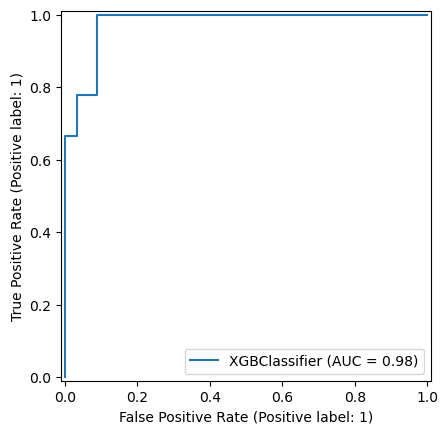

In [201]:
# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)

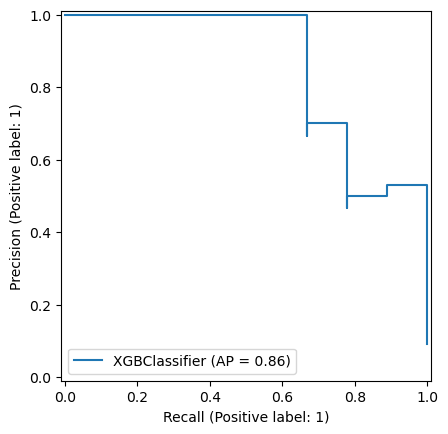

In [205]:
# PR Curve
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)

In [206]:
model.feature_importances_

array([0.06709281, 0.07790168, 0.15139008, 0.05080288, 0.6528125 ,
       0.        ], dtype=float32)

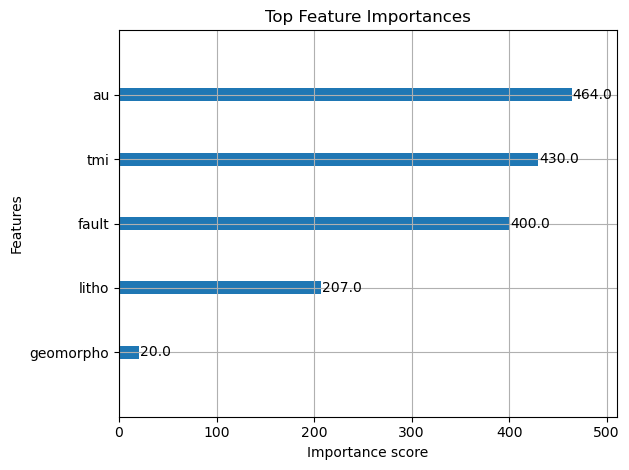

In [207]:
plot_importance(model, max_num_features=10)
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()

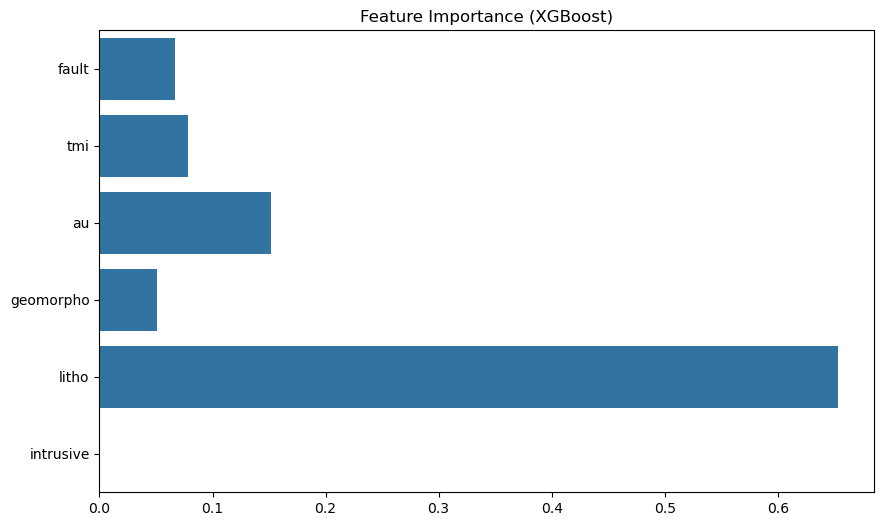

In [209]:
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=predictor_cols)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [210]:
X_full = df[predictor_cols]
y_pred_full = model.predict_proba(X_full)[:, 1]

In [213]:
prospectivity = np.full((profile['height'] * profile['width']), np.nan)
prospectivity[df.index] = y_pred_full
prospectivity = prospectivity.reshape((profile['height'], profile['width']))

In [215]:
prospectivity_masked = np.ma.masked_invalid(prospectivity)

In [216]:
p90 = np.nanpercentile(prospectivity, 90)

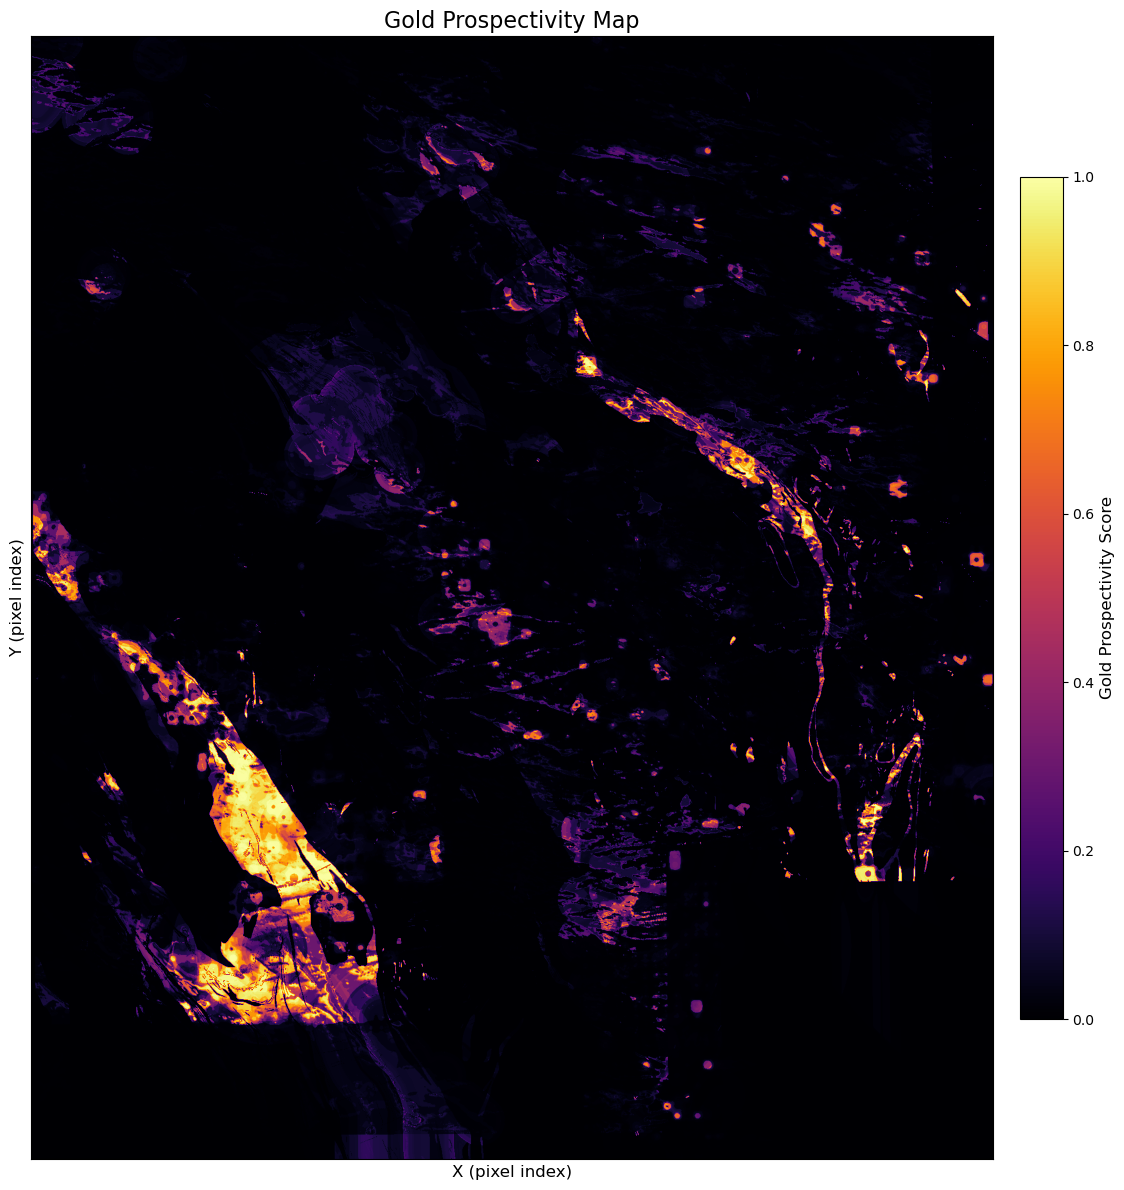

In [218]:
fig, ax = plt.subplots(figsize=(14, 12))
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=0, vmax=1)

cax = ax.imshow(prospectivity_masked, cmap=cmap, norm=norm, origin='upper')
cbar = fig.colorbar(cax, ax=ax, shrink=0.75, orientation='vertical', pad=0.02)
cbar.set_label('Gold Prospectivity Score', fontsize=12)

contour = ax.contour(prospectivity, levels=[p90], colors='cyan', linewidths=0.0)
#ax.clabel(contour, fmt={p90: 'P90'}, inline=False, fontsize=10)

ax.set_title("Gold Prospectivity Map", fontsize=16)
ax.set_xlabel("X (pixel index)", fontsize=12)
ax.set_ylabel("Y (pixel index)", fontsize=12)

#ax.text(0.01, 0.02, f"Threshold ≥ P90 = {p90:.2f}", transform=ax.transAxes,fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Gold_Prospectivity\Gold Prospectivity Map (with geomorpho).png",dpi=400)
plt.show()

# [2] Using XGBRegressor

In [4]:
raster_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Rasters"
rasters = {
    "Au_ppb": "Au_ppb.tif",
    "fault_distance": "fault_distance_raster.tif",
    "fold_distance": "fold_distance_raster.tif",
    "geomorph_class": "Geomorphological_Classification.tif",
    "intrusive_gold": "Intrusive_Gold.tif",
    "litho_gold": "Litho_Gold.tif",
    "resampled_tmi": "Resampled_TMI.tif",
    "Quartz": "Quartz_Mosaic_Processed_classified.tif",
    "Silica": "Silica_Mosaic_Processed_classified.tif",
    "AlOH_b6": "aioh_b6_Mosaic_Processed_classified.tif",
    "AlOH": "AiOH_Mosaic_Processed_classified.tif",
    "FeOH": "feoh_Mosaic_Processed_classified.tif",
    "FerricOxide Composition": "ferricoxide_comp_Mosaic_Processed_classified.tif",
    "FerricOxide": "ferricoxide_Mosaic_Processed_classified.tif",
    "FerrousIron MgOH": "ferrousiron_mgoh_Mosaic_Processed_classified.tif",
    "FerrousIron": "ferrousiron_Mosaic_Processed_classified.tif",
    "Gypsum": "Gypsum_Mosaic_Processed_classified.tif",
    "Kaolin group index (B6_B5)": "kaolin_Mosaic_Processed_classified.tif",
    "MgOH Group": "mgoh_grp_Mosaic_Processed_classified.tif",
    "MgOH": "mgoh_Mosaic_Processed_classified.tif",
    "Opaque": "opaque_Mosaic_Processed_classified.tif",
    "target": "Target_Map_Gold.tif"
}

In [48]:
predictor_cols = ['Au_ppb', 'fault_distance', 'fold_distance', 'geomorph_class', 'intrusive_gold', 'litho_gold', 'resampled_tmi',
                 'Quartz', 'Silica', 'AlOH_B6', 'AlOH', 'FeOH', 'FerricOxide Composition', 'FerricOxide', 'FerrousIron MgOH', 'FerrousIron',
                 'Gypsum', 'Kaolin group index (B6_B5)', 'MgOH Group', 'MgOH', 'Opaque']

In [5]:
# Load rasters one-by-one to minimize memory
arrays = []
mask = None

In [6]:
for i, (key, filename) in enumerate(rasters.items()):
    path = os.path.join(raster_dir, filename)
    with rasterio.open(path) as src:
        data = src.read(1).astype(np.float32)
        if i == 0:
            profile = src.profile
            shape = data.shape
        if key == "target":
            target = data
        else:
            arrays.append(data)

# Convert to stacked features
features = np.stack(arrays, axis=-1)


In [7]:
# Mask to ensure valid data only
valid_mask = np.all(~np.isnan(features), axis=-1) & ~np.isnan(target)
X = features[valid_mask]
y = target[valid_mask]

In [13]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# XGBRegressor model
model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42)

In [15]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
# Evaluation
y_pred = model.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


RMSE: 0.0282
R² Score: 0.8178


## PREVIOUS
#### RMSE: 0.0276
#### R² Score: 0.8259

C:\Users\Kunal\AppData\Local\Temp\ipykernel_1512\3499665559.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")


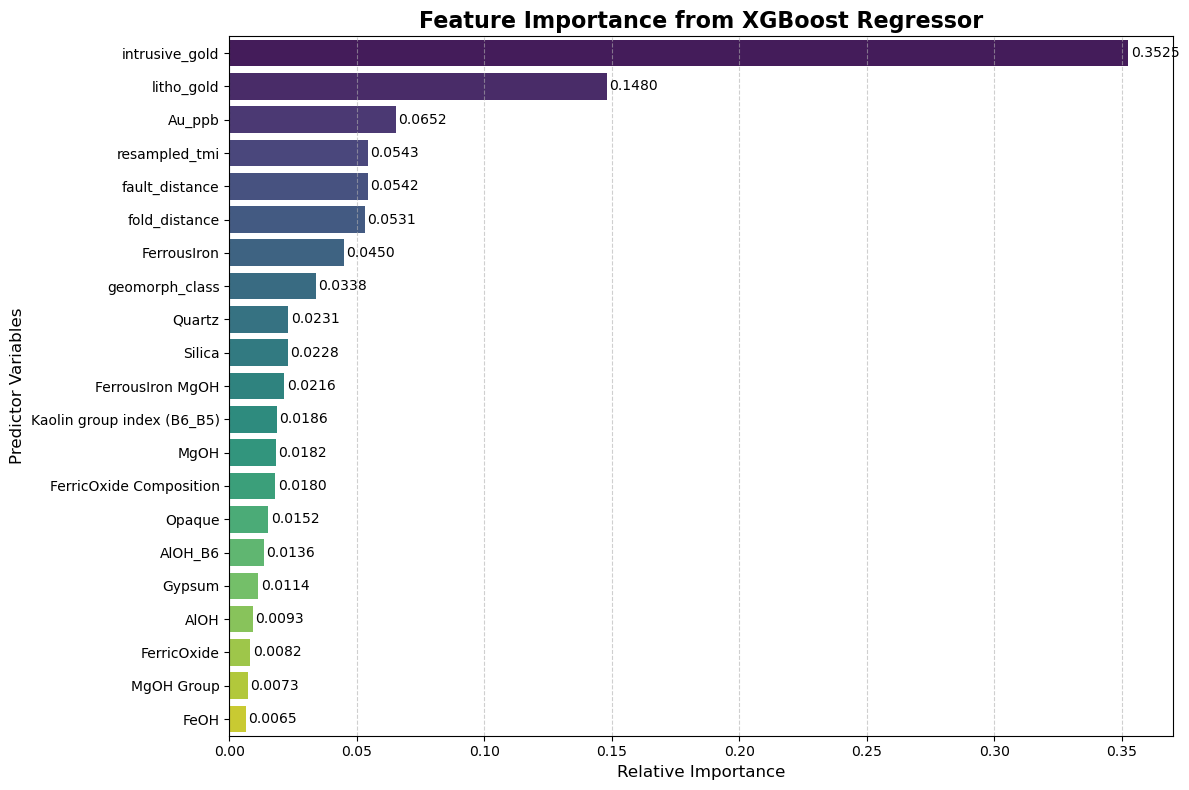

In [58]:
# Ensure predictor columns and importances are sorted by importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_features = [predictor_cols[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")

# Aesthetics
plt.title("Feature Importance from XGBoost Regressor", fontsize=16, fontweight='bold')
plt.xlabel("Relative Importance", fontsize=12)
plt.ylabel("Predictor Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars with values
for i, v in enumerate(sorted_importances):
    plt.text(v + 0.001, i, f"{v:.4f}", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Gold_Prospectivity\Feature Importance from XGBoost Regressor.png")
plt.show()

In [26]:
# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# Print results
print("Evaluation Metrics for Gold Prospectivity:")
print(f"RMSE:                  {rmse:.4f}")
print(f"MAE:                   {mae:.4f}")
print(f"R² Score:              {r2:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance:    {evs:.4f}")

Evaluation Metrics for Gold Prospectivity:
RMSE:                  0.0282
MAE:                   0.0104
R² Score:              0.8178
Median Absolute Error: 0.0029
Explained Variance:    0.8178


## PARAMETERS if trained with Spectral Indices (previous run)
###### RMSE:                  0.0276
###### MAE:                   0.0097
###### R² Score:              0.8259
###### Median Absolute Error: 0.0025
###### Explained Variance:    0.8259

## PARAMETERS if trained without Spectral Indices

###### Evaluation Metrics for Gold Prospectivity:
###### RMSE:                  0.0291
###### MAE:                   0.0095
###### R² Score:              0.8063
###### Median Absolute Error: 0.0017
###### Explained Variance:    0.8063

In [28]:
# Predict on full image
full_pred = np.full(shape, np.nan, dtype=np.float32)
full_pred[valid_mask] = model.predict(X)

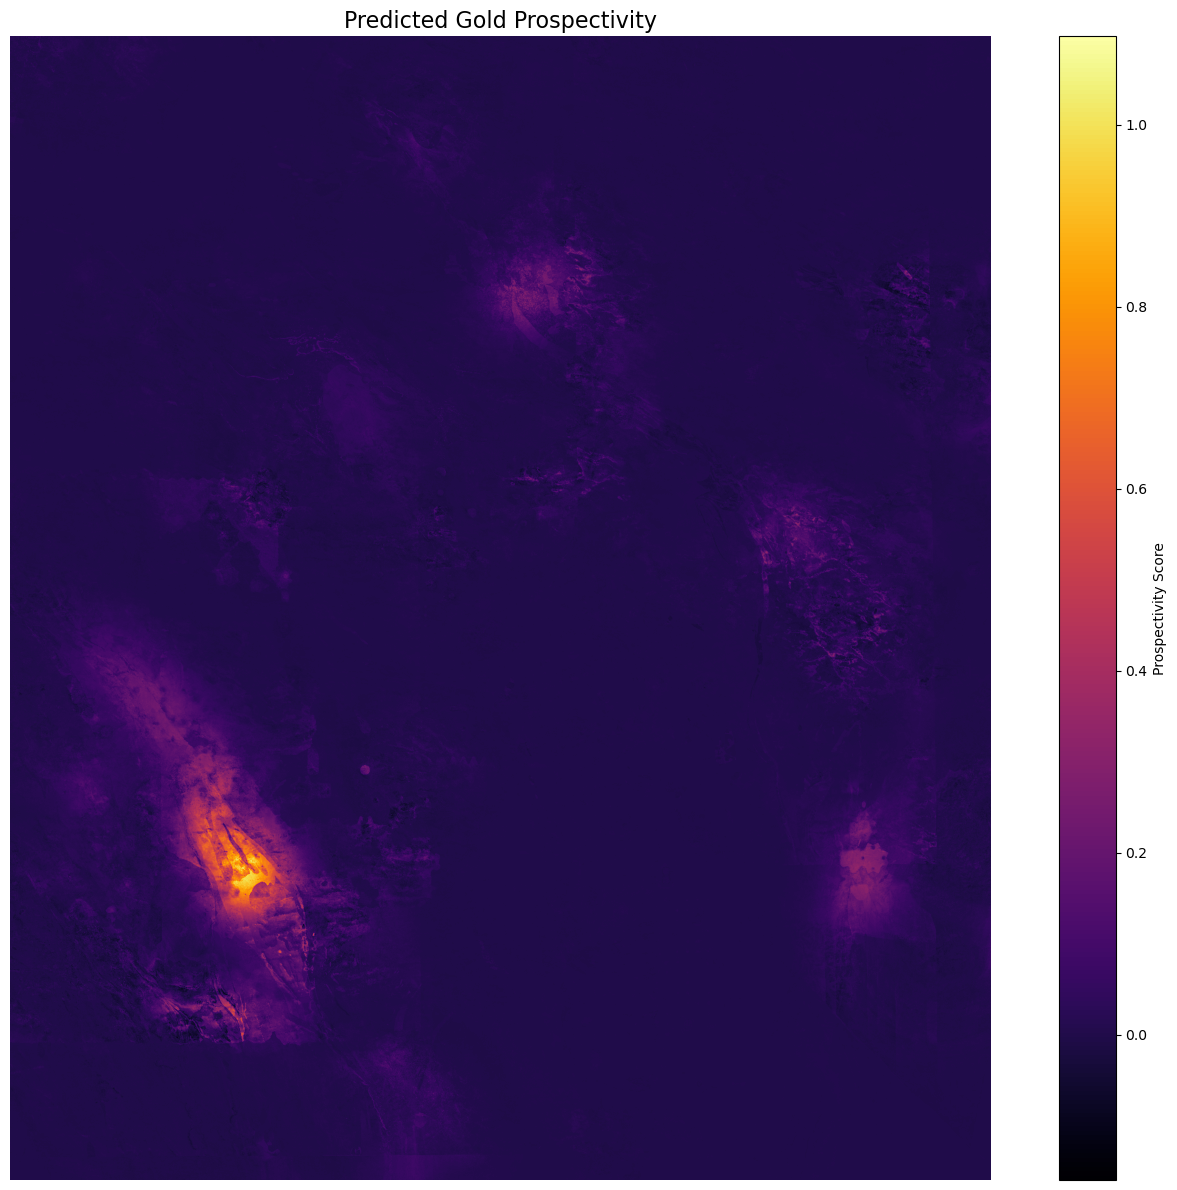

In [30]:
# Plotting
plt.figure(figsize=(14, 12))
img = plt.imshow(full_pred, cmap='inferno')
plt.xlabel("X (pixel index)", fontsize=12)
plt.ylabel("Y (pixel index)", fontsize=12)
plt.title("Predicted Gold Prospectivity", fontsize=16)
plt.colorbar(img, label="Prospectivity Score")
plt.axis('off')
plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Gold_Prospectivity\Gold Prospectivity Map - Regressor with Indices-provisional.png",dpi=400)
plt.show()

In [80]:
# 1. Base Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
maxerr = max_error(y_test, y_pred)

# 2. Percentage-Based
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = 100/len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test) + 1e-8))

# 3. Normalized Error Metrics
y_range = np.max(y_test) - np.min(y_test)
nrmse_range = rmse / y_range
nrmse_mean = rmse / np.mean(y_test)

# 4. Bias
mbe = np.mean(y_pred - y_test)

# 5. Correlation-Based
pearson_corr, _ = pearsonr(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)
kendall_corr, _ = kendalltau(y_test, y_pred)

# ---- Print All Metrics ----
print("Evaluation Metrics for Gold Prospectivity:")
print(f"RMSE:                  {rmse:.4f}")
print(f"MSE:                   {mse:.4f}")
print(f"MAE:                   {mae:.4f}")
print(f"R² Score:              {r2:.4f}")
print(f"Median Absolute Error: {medae:.4f}")
print(f"Explained Variance:    {evs:.4f}")
print(f"Max Error:             {maxerr:.4f}")
print(f"MAPE (%):              {mape:.2f}")
print(f"SMAPE (%):             {smape:.2f}")
print(f"Normalized RMSE (range): {nrmse_range:.4f}")
print(f"Normalized RMSE (mean):  {nrmse_mean:.4f}")
print(f"Mean Bias Error (MBE):   {mbe:.4f}")
print(f"Pearson Corr:            {pearson_corr:.4f}")
print(f"Spearman Corr:           {spearman_corr:.4f}")
print(f"Kendall Corr:            {kendall_corr:.4f}")

Evaluation Metrics for Gold Prospectivity:
RMSE:                  0.0282
MSE:                   0.0008
MAE:                   0.0104
R² Score:              0.8178
Median Absolute Error: 0.0029
Explained Variance:    0.8178
Max Error:             0.7638
MAPE (%):              14525179887616.00
SMAPE (%):             173.59
Normalized RMSE (range): 0.0282
Normalized RMSE (mean):  1.8971
Mean Bias Error (MBE):   0.0000
Pearson Corr:            0.9057
Spearman Corr:           0.4816
Kendall Corr:            0.3779


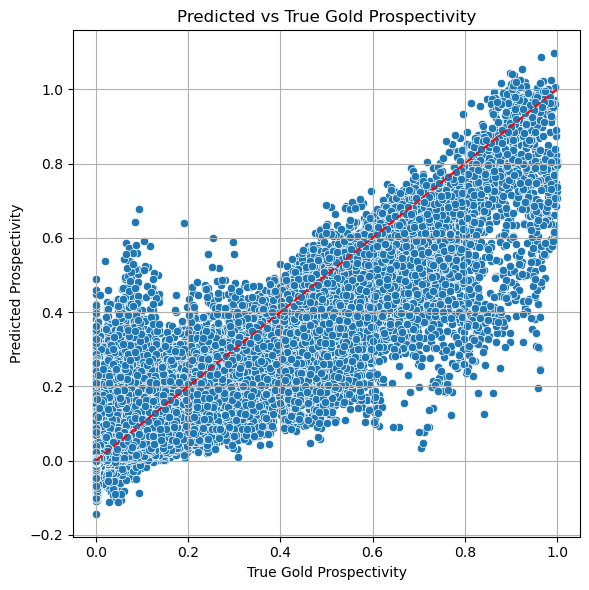

In [90]:
# 1. Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel("True Gold Prospectivity")
plt.ylabel("Predicted Prospectivity")
plt.title("Predicted vs True Gold Prospectivity")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Gold_Prospectivity\Predicted vs True Gold Prospectivity.png",dpi=200)
plt.show()

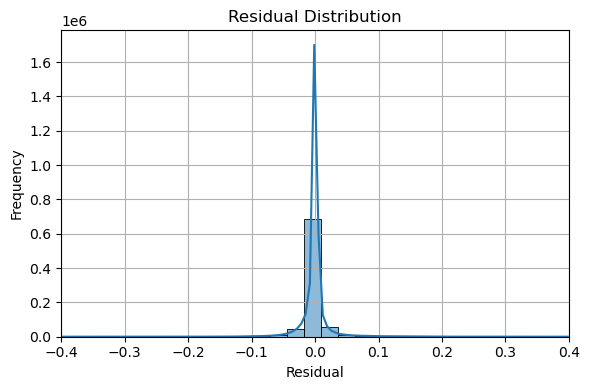

In [92]:
# 2. Residual Histogram
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim(-0.4, 0.4)
plt.grid(True)
plt.savefig(r"C:\Data\ONGC\AIKosh\OUTPUT\Mineralization\Gold_Prospectivity\Residual Distribution.png",dpi=200)
plt.tight_layout()
plt.show()

In [94]:
# Verify TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Verify NumPy
import numpy as np
print("NumPy version:", np.__version__)

# Verify Rasterio
import rasterio
print("Rasterio version:", rasterio.__version__)

# Verify scikit-learn
import sklearn
print("scikit-learn version:", sklearn.__version__)

# Verify Matplotlib
import matplotlib
print("Matplotlib version:", matplotlib.__version__)


TensorFlow version: 2.19.0
Keras version: 3.9.2
NumPy version: 1.26.4
Rasterio version: 1.4.3
scikit-learn version: 1.5.1
Matplotlib version: 3.9.2
